In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Exercise 6.1

Show empirically that the information limit of 2 prediction bits per parameter also holds for nearest neighbors.

In [45]:
# Load binary classification dataset
dataset = load_breast_cancer()
X = dataset.data
y = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Describe the data: number of samples, number of features, what the features are, and the classes
print(X.shape)
print(f"Features: {dataset.feature_names}")
print(f"Classes: {dataset.target_names}")

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=9, metric='minkowski', p=2)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(accuracy_score(y_test, y_pred))

(569, 30)
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Classes: ['malignant' 'benign']
0.9473684210526315


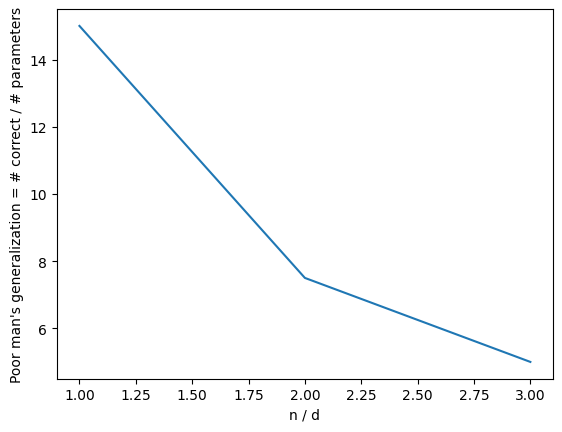

In [84]:
n, d = X.shape
# Create a plot of the accuracy of the model as a function of the number of features (d) divided by the number of samples (n)
results = []

for num_points in range(d, 4 * d):
    X_train, y_train = X_train[:num_points], y_train[:num_points]
    num_params = num_points // d
    classifier = KNeighborsClassifier(n_neighbors=num_params, metric='minkowski', p=2)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    num_correct = np.sum(y_pred == y_test)
    results.append((num_params, num_correct / num_params))

# y axis is num_correct / num_params, x axis is num_params
plt.plot(*zip(*results))
plt.xlabel("n / d")
plt.ylabel("Poor man's generalization = # correct / # parameters")
plt.show()   


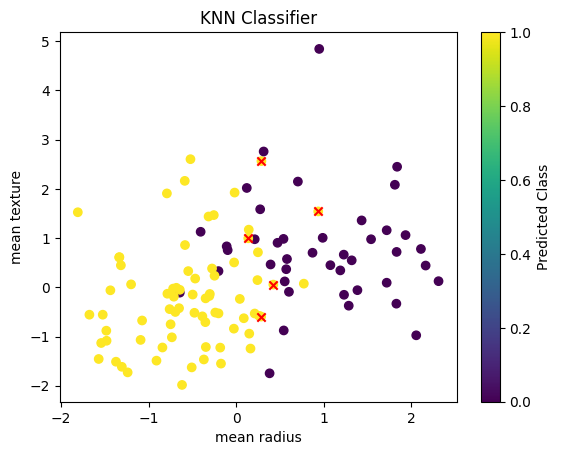

In [39]:
# Plot the results using the predicted labels as colors. Label misclassified points with red Xs.
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
plt.scatter(X_test[y_pred != y_test, 0], X_test[y_pred != y_test, 1], c='r', marker='x')
plt.xlabel(dataset.feature_names[0])
plt.ylabel(dataset.feature_names[1])
plt.title('KNN Classifier')
plt.colorbar(label='Predicted Class')
plt.show()


# Exercise 6.2

Implement a program that automatically creates a set of if-then clauses from the training table of a binary dataset of your choice. Implement different strategies to minimize the number of if-then clauses. Document your strategies, the number of resulting conditional clauses, and the accuracy achieved.

if (worst perimeter <= 105.95) and (worst concave points <= 0.135) and (area error <= 48.975) and (worst texture <= 30.145) then class: benign (proba: 100.0%) | based on 274 samples
if (worst perimeter > 105.95) and (worst perimeter > 117.45) and (fractal dimension error > 0.002) then class: malignant (proba: 100.0%) | based on 164 samples
if (worst perimeter <= 105.95) and (worst concave points <= 0.135) and (area error <= 48.975) and (worst texture > 30.145) and (worst texture > 30.265) and (worst smoothness <= 0.141) then class: benign (proba: 100.0%) | based on 33 samples
if (worst perimeter > 105.95) and (worst perimeter <= 117.45) and (worst smoothness > 0.136) and (worst texture > 17.53) then class: malignant (proba: 100.0%) | based on 22 samples
if (worst perimeter > 105.95) and (worst perimeter <= 117.45) and (worst smoothness <= 0.136) and (worst texture <= 25.67) then class: benign (proba: 100.0%) | based on 20 samples
if (worst perimeter <= 105.95) and (worst concave points

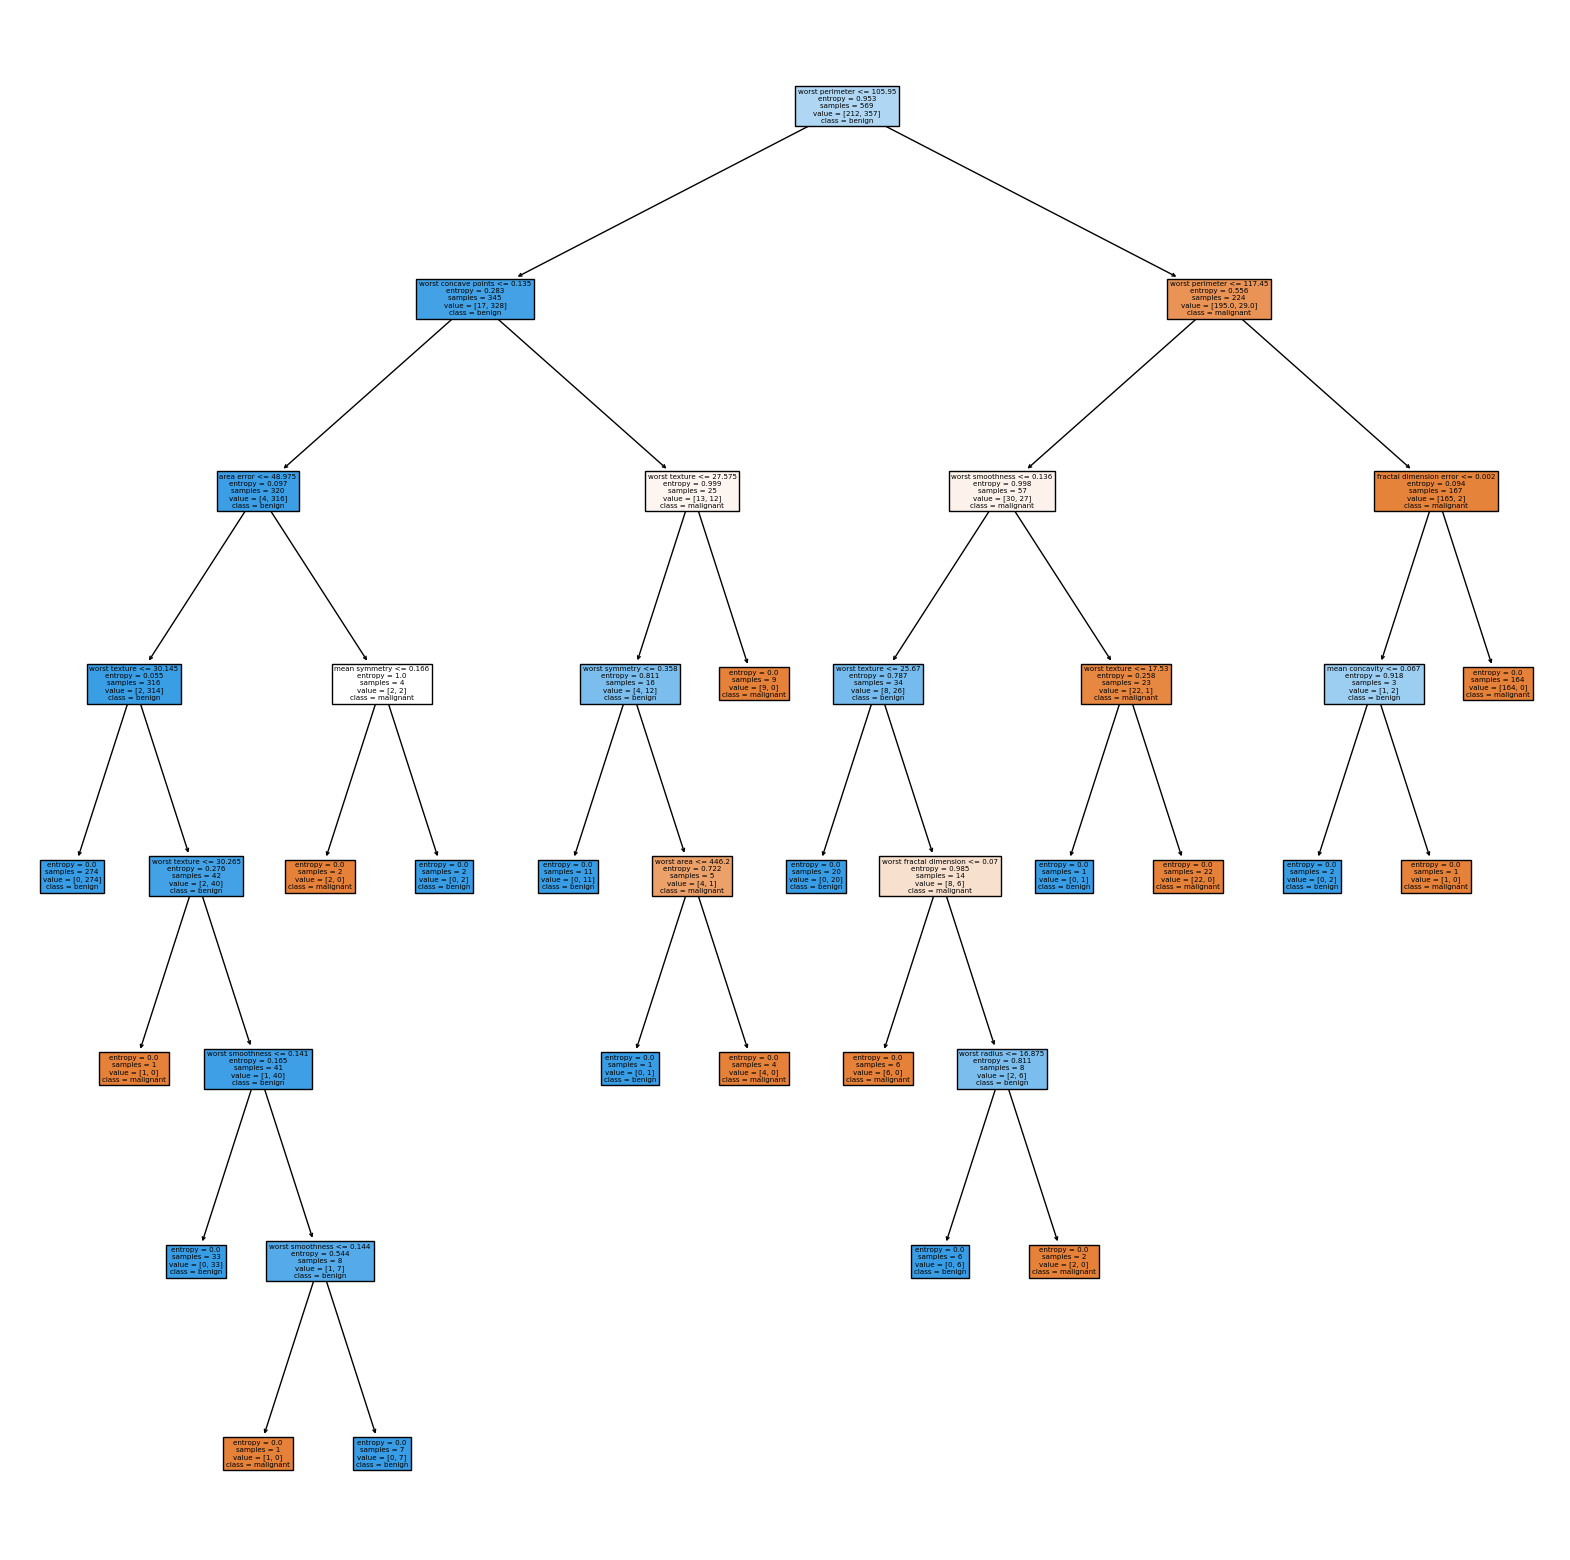

In [160]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree

dataset = load_breast_cancer()
X = dataset.data
y = dataset.target

clf = DecisionTreeClassifier(random_state=0, criterion='entropy') # A decision tree is really just a bunch of if-then-else statements
clf.fit(X, y)
y_pred = clf.predict(X)

# Get the tree as a list of if-then clauses
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

rules = get_rules(clf, dataset.feature_names, dataset.target_names)

for r in rules:
    print(r)


# Get number of non-leaf nodes
n_nodes = clf.tree_.node_count
num_leaf_nodes = np.sum(clf.tree_.children_left == -1)
print(f"Number of nodes in the decision tree: {n_nodes}")
print(f"Number of non-leaf nodes (if-then clauses): {n_nodes - num_leaf_nodes}")

# Print decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 20))
plot_tree(clf, filled=True, feature_names=dataset.feature_names, class_names=dataset.target_names)
plt.show()

# Exercise 6.3

Create a long random string using a Python program, and use a lossless compression algorithm of your choice to compress the string. Note the compression ratio.

In [213]:
# Create a long random string using a Python program, and use a lossless compression algorithm of your choice to compress the string. Note the compression ratio.

import zlib

# Random bit string
s = ''.join([str(np.random.randint(0, 2)) for _ in range(20)])

compressed = zlib.compress(s.encode('utf-8'))
print(f"Original length: {len(s)}")
print(f"Compression ratio: {len(s) / len(compressed)}")

Original length: 20
Compression ratio: 1.0


In [214]:
import math
def entropy(s):
    _, counts = np.unique(list(s), return_counts=True) # Get the unique characters and their counts
    p = counts / len(s)
    return -np.sum(p * np.log2(p))

def ideal_entropy(n):
    p = 1 / n
    return -n * p * np.log2(p)
print(f"Shannon entropy of the string: {entropy(s)}")
print(f"Entropy of a truly random string of the same length: {ideal_entropy(len(s))}")

Shannon entropy of the string: 0.934068055375491
Entropy of a truly random string of the same length: 4.321928094887363


What is the expected compression ratio? Explain why.

Assuming we have a truly random bit generator - which we don't, and cannot have - then the entropy of each bit is $log_2(0.5) = -1$. Since the bits are truly independent, we cannot compress the string, yielding a theoretical compression ratio of 1. However, in practice, we can compress the string, since the bits are not truly independent. The lower the entropy of the string, the higher the compression ratio. Hence, we see a compression ratio of slightly more than 1. 